In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import fdtd
from tqdm import tqdm_notebook as tqdm
from IPython.display import HTML
from matplotlib import animation
#get_ipython().run_line_magic('matplotlib', 'inline')

In [9]:
# the whole thing in function form:

# specs I grabbed from a random edmund optic asphere
LENS = {
    'radius': 5, # radius of the lens
    'curve': 1.982161E-01, # main curvature
    'k': -1.055033 ,
    'As': [
        0,             # A2
        5.096600E-04,  # A4
        2.254951E-06,  # A6
        8.064402E-09,  # A8
        -9.079062E-10] # A10
}

def asphere(n, radius=5, curve=2, k=-1, As=[]):
    """returns a lens surface with `n` samples
    """
    s = np.linspace(-radius, radius, n)
    z = curve * s**2 / (1 + np.sqrt(1 - (1 + k) * curve**2 * s**2))
    for n, A in enumerate(As):
        z += A*s**(n*2 + 2)
    return z


def setup_grid(
    width = 30e-6,
    height = 20e-6,
    pixel = 50e-9,
    wavelength = 600e-9,
    lens=LENS,
    lens_scale=1,
    lens_position=6.5,
    extra_glass=1,
    refractive_index = 1.68,
    bes=None
):
    if bes:
        # enforce odd pixels for symmetry
        height += pixel
    grid = fdtd.Grid(shape = (height, width, 1),grid_spacing = pixel)
    # to avoid reflections at the edges, add "perfectly matched layers" (PML)
    grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
    grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")
    grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
    grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

    if bes:
        grid[grid.Nx//2 - bes:grid.Nx//2 - bes+2, 13, 0] = fdtd.LineSource(period=wavelength/299792458, name="p1")
        grid[grid.Nx//2 + bes:grid.Nx//2 + bes+2, 13, 0] = fdtd.LineSource(period=wavelength/299792458, name="p2")
    else:
        grid[:, 11, 0] = fdtd.LineSource(period=wavelength/299792458, name="source")
        
    surface = asphere(grid.Nx, **lens)
    _pix = (lens['radius']*2) / (grid.Nx-1) # mm
    surface /= _pix
    ny = int(surface.max() + (extra_glass/_pix))
    _lens, yy = np.mgrid[:len(surface), :ny]
    _lens = np.zeros_like(yy)
    _lens[yy>surface[:, np.newaxis]] = 1
    _perm = np.ones((*_lens.shape,1))
    _perm += np.array(_lens[:,:,None])*(refractive_index**2 - 1)
    lens_start = int(_lens.shape[0]/lens_position)
    lensobj = fdtd.Object(permittivity=_perm, name="lens")
    grid[:, lens_start:lens_start + _lens.shape[1], 0] = lensobj
    return grid

def capture_frames(grid, total_time=1000, dt=10):
    frames = []
    grid.reset()
    for t in tqdm(np.arange(0, total_time, dt)):
        grid.run(total_time=dt, progress_bar=False)
        frames.append(np.sum(grid.E, -1)[:, :, 0])
    return frames

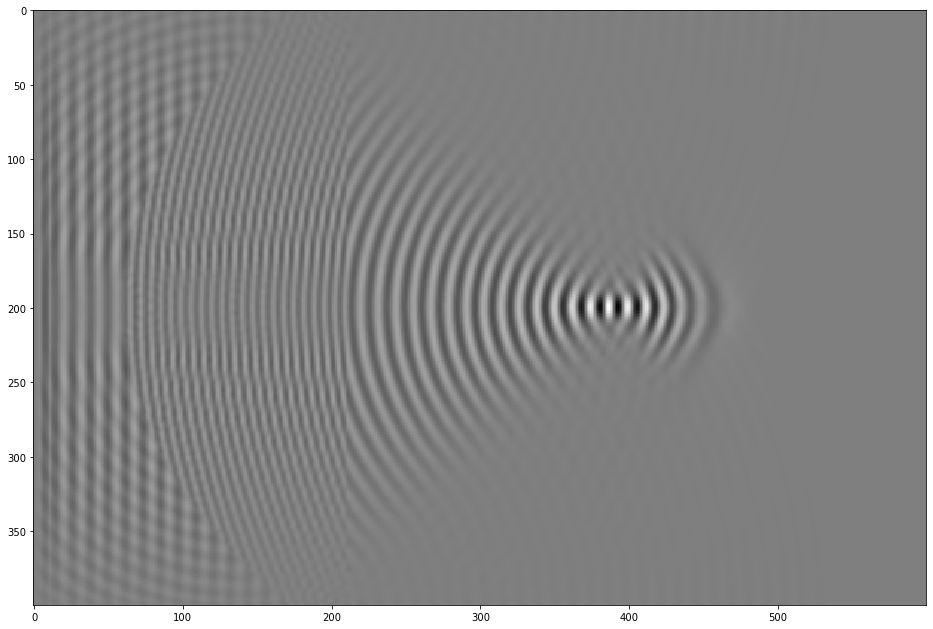

In [10]:
mygrid = setup_grid()
frms = capture_frames(mygrid, 800, 20)
plt.figure(figsize=(16,16))
plt.imshow(frms[-1], cmap='gray')

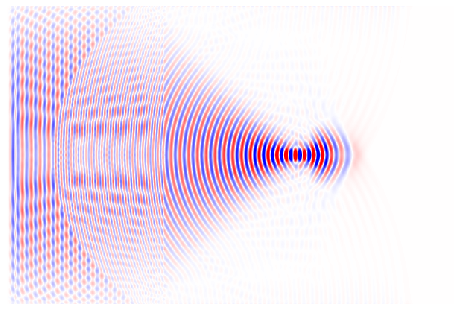

In [11]:
def plot_images(frames, fps=10):

    def animate(i):
        im.set_data(frames[i])
        return (im,)

    fig = plt.figure(frameon=False, figsize=(8,8))
    im = plt.imshow(frames[0], cmap='bwr', vmin=-0.005, vmax=0.005)
    plt.axis('off')
    anim = animation.FuncAnimation(fig, animate,
                                   frames=tqdm(range(len(frames))),
                                   interval=1000/fps, blit=True)
    return anim

anim=plot_images(frms)
HTML(anim.to_html5_video())

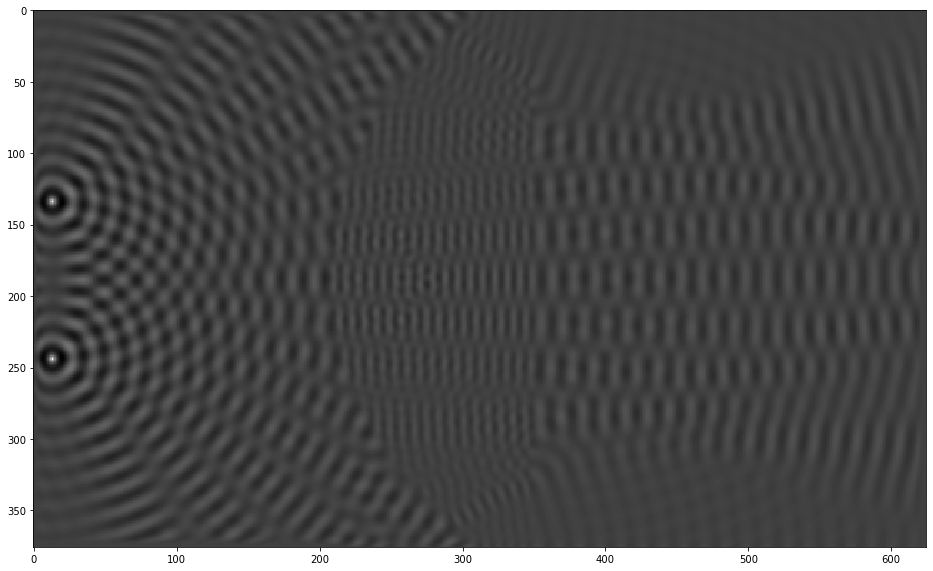

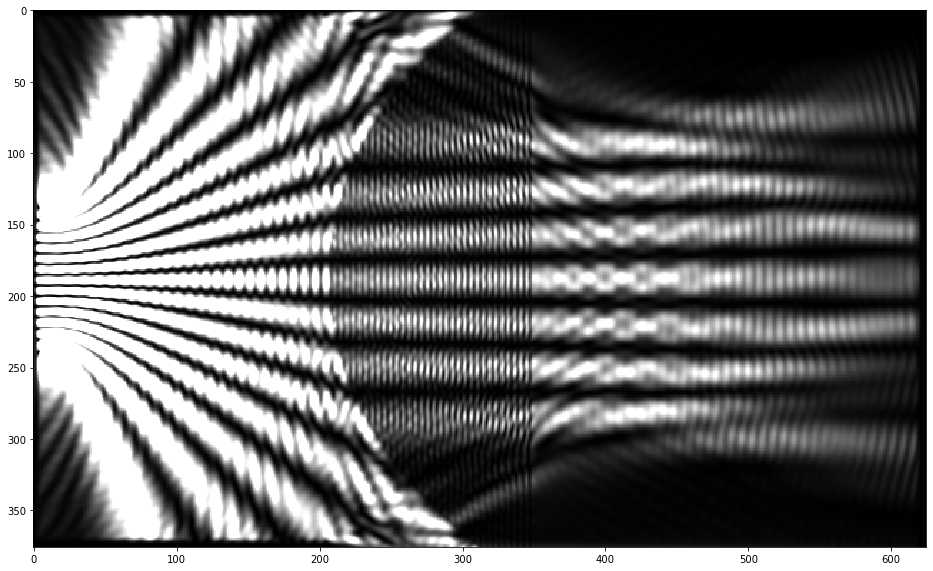

In [12]:
#something approaching a bessel??
# one challenge here is positioning the points in the BFP
# of the lens... whose focal length is unclear?
# i guess there's a challenge for you!
# you could send a plane wave in the back side :)
mygrid = setup_grid(width=25e-6, height=15e-6, pixel=40e-9,
                    bes=55, lens_position=1.8)
frms = capture_frames(mygrid, 1200, 10)
plt.figure(figsize=(16,16))
plt.imshow(frms[-1], cmap='gray')
plt.figure(figsize=(16,16))
plt.imshow((np.stack(frms[-40:])**2).mean(0), cmap='gray', vmax=0.0003)